In [1]:
import numpy as np
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams["figure.dpi"] = 200

In [19]:
TRAIN_SEQUENCE = open("train_set.txt").read().strip().replace("\n", "")
TEST_SEQUENCE = open("test_set.txt").read().strip().replace("\n", "")

In [17]:
TRAIN_SEQUENCE

'GGTGGAGCGCGCCGCCACGGACCACGGGCGGGCTGGCGGGCGAGCGGCGAGCGCGCGGCGATCCGAGCCCCTAGGGCGGATCCCGGCTCCAGGCCCGCGCGCGCCTCAGGCCGTTTCCCTATTTAAGGCCTCGCCGCCGCGGGGTGTGTGAACCCGGCTCCGCATTCTTTCCCACACTCGCCCCAGCCAATCGACGGCCGCGCTCCTCCCCCGCTCGCTGTCAGTCACGCCTCGGCTCCGGGCGCGGCCTCCGCGGGCGACAATGGCATGCGGGGCCCCCGCCCGCGCCCCCCTCCGACACCGCTGGGGACAGGGCCGGGTGATCCCGCGCTCCCCGATGCAGCCGGGGCCGAGCAACGCGCCGGGAGGGGCCGCTGGGGGCGAACGGGGCCCGGGACCCCCGGGGCTGGGCGGAGTCTCGGGGCTCACTCTCCCGCCCAGGGGGCCGGGAGCCGGGGCTGGACGGAGCTGGGGCTGTGGCCGCGCGGGAAGTCGGGAAGGAAATTCCCCCAGTGGCGCAGGGTCCGGCGGCGCCGAGGGGTGGGCGAGCCTCGGTCTCGAGCCTCTTGGCTTCCTCCGCCCGTCCCCACTCCGGTCCCGGTTTGGGCCCTGCTCGGTCTCCGAGTTTGATCCGACACCGGCTCGGCCTCCGGGGGTCCCACCCTCAGGTGTGCGGCCTGGAGCACGGAGGGCTGCAGAAAGCCTTGGGAGCGACAGAGCCGGGGGAAGGTCGGCGGCCGGGTCGGCAGGCGGGAGGGCGGAGTCAGCGGACGGCGAAGGGGCGCACGGGTGGCCCCGCAGAGCAGGGCCGGTGATGGCGCGGGCCGGGCCGGACCACGAGGAGCAGAACGTGCGCGTGACGCGAGCGGGCTGGTGACGTCACCAGGCACCCGGGGCGATGACGCAAGCCTGCTGGGATGACGTCATGTGGCCCGTGTCGCCACGTGCTTCCAGGTGACCCGCTGGCGAACTCAGCAGCAGCAAAGTGGGGCTCACAGA

In [20]:
TEST_SEQUENCE

'CCAGCTATTCTGGAGACTGAGGCAGGAGGATCACTTGAGCCCAGGAGTTTGAGCAGTACTAGACTTTACCTTGGGCAAAAAGGCAAGACCCCATCTCTTAAAAAACAAATACATAGACGGACAGACAGACACACACACCACAGTGCATCTTTTGTAGACAGCATGTAGTAAATCTTGCTAATTTGTCCATTTTAGCAATCTCTGCCTTTTAACTGGAGGGTTTAATTCATTAATATTTAATATAATTATCATTATGGGTAGATGTAGGTATGTTAATATTTAATATAATTACTGTTATGGGTAGATGTAGGTATGTTAATCGTTTTCTGATTGTCCCTTTGTATACACACGCTGCCCTTTATTTTTCAGTGATTTTAGGTTCATAGCAAAATTGAGCAGTTAAGTACAAGGAGTTGTGCCTCCCCGCTGTGCCCACCCAGGCACAGCCTTACCCTCAGCATCCCACTTGTTGCAGCTGACACACCGACAGTGACACATCACCACCACTCAAAGTCCATGGTTGACACGAGGGCGCACTCTTGGTGCTGCACGTTCTTGGTGCTGAGCTTTGGCAAGTGTATAATGACACTATCGTTGGATTTCAGGTCTACCGTTTTTACCGTTTATTATTTGTTTTCTGATTGTCCCTGTGTTTTTTGTTCCTCTATTCTCTTTCTGGCCCTCTTTTGCGTGATTTGAAGTTTTAAAAATTCCTTTCCAAGTTATCTTTTGGCCCTTTAGTTGTGCTTCTTTCCATTATTCTCATAGTTGTTGCTCTAGGAATTGCAATTTCAACCTTGCTTTTTCTAGTCTACTTAGAACTAGCATTATACCACTTTATGCAAAATGTAGACATGTAGACACCTTGCAACTGTACAGTCCACGGATCCCCTCTACTACTCTTCACGTTGTGGCTGTCATATCTGCATACATTATAAACCCAAGAGATGTTTTAATTTTTCCCCAGATATTTACTAATTTTGATGTTCATCATTCATT

In [21]:
class MarkovChain:
    def __init__(self, n_lookback=1, vocab="ACGT"):
        assert n_lookback > 0

        self.letter_to_idx = {x: i for i, x in enumerate(vocab)}
        self.state_to_idx = {"".join(p): i for i, p in enumerate(itertools.product(vocab, repeat=n_lookback))} # fmt: skip
        self.n_lookback = n_lookback
        self.vocab_size = len(vocab)
        self.vocab = vocab

        m_dim = np.power(self.vocab_size, n_lookback)
        n_dim = self.vocab_size

        self.transition_matrix = np.zeros((m_dim, n_dim), dtype=np.float32)

    def train(self, sequence):
        assert len(sequence) >= self.n_lookback
        for i in range(self.n_lookback, len(sequence)):
            curr_state_idx = self.state_to_idx[sequence[i - self.n_lookback : i]]
            next_state_idx = self.letter_to_idx[sequence[i]]
            self.transition_matrix[curr_state_idx, next_state_idx] += 1.0

        # This is called Laplace smoothing, basically to avoid zeros probabilities
        self.transition_matrix += 1.0
        normalization = np.sum(self.transition_matrix, axis=1, keepdims=True)
        self.transition_matrix /= normalization

    def test(self, sequence):
        assert len(sequence) >= self.n_lookback
        correct_count = 0

        for i in range(self.n_lookback, len(sequence)):
            curr_state = sequence[i - self.n_lookback : i]
            next_state = sequence[i]
            if self.next_state(curr_state, method="greedy") == next_state:
                correct_count += 1
        accuracy = correct_count / (len(sequence) - self.n_lookback)
        print(f"Accuracy: {accuracy:.4f}")

    def next_state(self, current_state, method="random"):
        assert method in ["random", "greedy"]
        assert len(current_state) == self.n_lookback
        curr_state_idx = self.state_to_idx[current_state]

        if method == "random":
            next_state = np.random.choice(
                self.vocab_size, p=self.transition_matrix[curr_state_idx]
            )
        elif method == "greedy":
            next_state = np.argmax(self.transition_matrix[curr_state_idx])

        return self.vocab[next_state]

    def simulate(self, start_state, num_steps=1):
        assert self.n_lookback == len(start_state)

        states = start_state.copy()
        for _ in range(num_steps):
            states += self.next_state(states[-self.n_lookback :], method="random")
        return states

    def plot_heatmap(self):
        if self.n_lookback > 4:
            print("Too big to plot. Please use a smaller n_lookback if you want to see the plot.") # fmt: skip
            return
        sns.set_theme(context="paper")
        transition_matrix = self.transition_matrix
        vocab = list(self.vocab)
        states = list(self.state_to_idx.keys())

        df = pd.DataFrame(transition_matrix, index=states, columns=vocab)
        fig, ax = plt.subplots(figsize=(8, 0.5 * len(states)))
        sns.heatmap(df, cbar=True, cbar_kws={"orientation": "horizontal",}, ax=ax, vmin=0, vmax=1) # fmt: skip

        ax.xaxis.tick_top()
        ax.set_xlabel("Next State")
        ax.set_ylabel("Starting State")
        ax.set_title("Transition Matrix Heatmap", pad=20)

        plt.tight_layout()
        plt.show()

In [25]:
for n in [1, 2, 3, 4, 5, 6, 7,8,9]:
    print(f"Markov Chain with n_lookback={n}")
    model = MarkovChain(n_lookback=n, vocab="ACGT")
    model.train(TRAIN_SEQUENCE)
    model.test(TEST_SEQUENCE)

Markov Chain with n_lookback=1
Accuracy: 0.2210
Markov Chain with n_lookback=2
Accuracy: 0.2523
Markov Chain with n_lookback=3
Accuracy: 0.2535
Markov Chain with n_lookback=4
Accuracy: 0.2447
Markov Chain with n_lookback=5
Accuracy: 0.2711
Markov Chain with n_lookback=6
Accuracy: 0.2734
Markov Chain with n_lookback=7
Accuracy: 0.2757
Markov Chain with n_lookback=8
Accuracy: 0.2769
Markov Chain with n_lookback=9
Accuracy: 0.2893


Accuracy: 0.2523


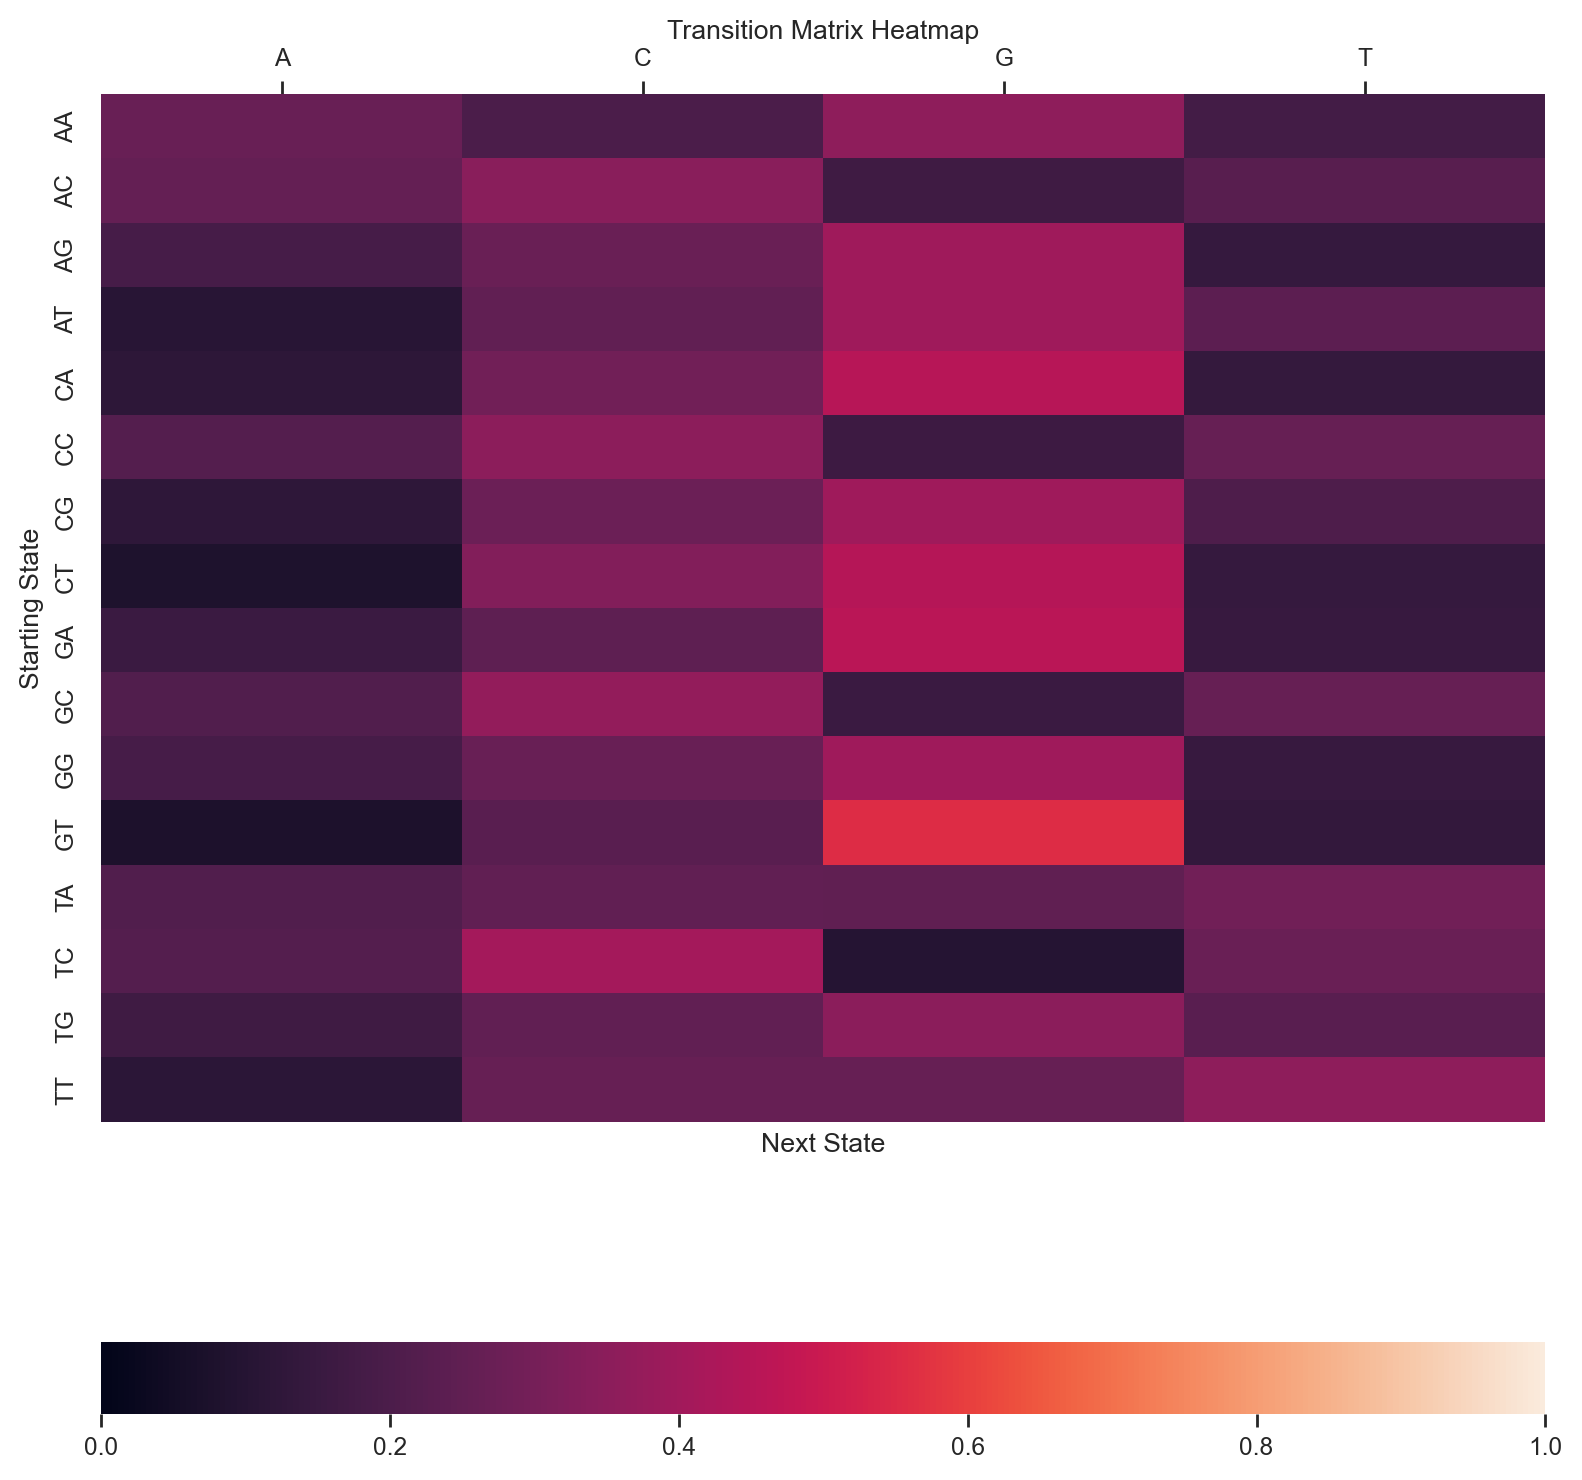

In [23]:
model = MarkovChain(n_lookback=2, vocab="ACGT")
model.train(TRAIN_SEQUENCE)
model.test(TEST_SEQUENCE)
model.plot_heatmap()

In [24]:
model = MarkovChain(n_lookback=7, vocab="ACGT")
model.train(TRAIN_SEQUENCE)
model.test(TEST_SEQUENCE)
model.plot_heatmap()

Accuracy: 0.2757
Too big to plot. Please use a smaller n_lookback if you want to see the plot.
